# Image Comparison with Image Quality Assessment (IQA)

This notebook can be used to compare two images / volumes using different IQA metrics. The metrics used are:
- Peak Signal to Noise Ratio (PSNR)
- Root Mean Square Error (RMSE)
- Structured Similarity (SSIM)
- Multi-Scale Structural Similarity (MS-SSIM) [can only be used for 2D images]
- Feature Similarity Index (FSIM) [can only be used for 2D images]
- Visual Information Fidelity in *pixel* domain (VIFp) [can only be used for 2D images]
- Visual Saliency Index (VSI) [can only be used for 2D images]
- Most Apparent Distortion (MAD)

Implemented, but not currently usable due to experimental nature of the implementation:
- Gradient Similarity (GSM) --> **untested**

**Important Notes:**
The calculated values for VIFp are probably not correct in this implementation. Those values should be treated with caution. Further testing is required.

**Usage:**
The metrics are implemented to calculate the scores for a 8 bit data range (0-255) per default. The data range can be changed by setting the `data_range` variable for each metric. Images are first loaded from .raw files or .mhd files and their corresponding .raw file, normalized to the chosen data range and then compared. The scores are then calculated and printed. The images are plotted to visually compare them. File names need to be given with the bit depth denoted as a suffix (e.g. _8bit.raw, _16bit.mhd) and the dimensions of the images need to be given in the file name (e.g. _512x512x512_). The images are assumed to be grayscale.

To use this notebook, first set the filepaths and parameters, then press 'Run All'.

**Requirements:**
The following packages have to be installed:
- numpy
- scipy
- matplotlib
- pytorch
- piq
- scikit-image
- jupyter

## Import

In [1]:
import vIQA
from vIQA import load_data
import matplotlib.pyplot as plt

## Data Loading and Setup

In [2]:
# Change these filepaths to your images (_r = reference, _m = modified)
file_path_img_r = '../samples/Catec_Two_PlateIQI_20um/Catec_Two_PlateIQI_20um_1620proj_220kV_Rayscan-SimCT_800x800x1000_16bit.raw'
file_path_img_m = '../samples/Catec_Two_PlateIQI_20um/Catec_Two_PlateIQI_20um_810proj_220kV_Rayscan-SimCT_800x800x1000_16bit.raw'

# Set these to true if you want to calculate the denominated metric for your data
calc_psnr = True
calc_rmse = True
calc_ssim = False
calc_msssim = False
calc_fsim = False
calc_vif = False
calc_vsi = False
calc_mad = True

In [3]:
# Data loading
img_r = load_data(file_path_img_r, data_range=255, normalize=True, batch=False)
img_m = load_data(file_path_img_m, data_range=255, normalize=True, batch=False)

In [4]:
# Set slice for 2D-metric calculation
img_r_slice, img_m_slice = img_r[0:1000, 200, 0:800], img_m[0:1000, 200, 0:800]

## Calculation

### PSNR
Set the parameters for PSNR. The data range is set to 255 per default.

In [5]:
# Change this parameter
psnr_load_parameters = {'data_range': 255}

In [6]:
if calc_psnr:
    metric_psnr_m = vIQA.PSNR(**psnr_load_parameters)
    metric_psnr_m.score(img_r, img_m)

### RMSE
The RMSE metric does not need any parameters.

In [7]:
if calc_rmse:
    metric_rmse_m = vIQA.RMSE()
    metric_rmse_m.score(img_r, img_m)

### SSIM
Set the parameters for SSIM. The data range is set to 255 per default. The chromatic parameter can be set to true if the images are RGB images. Alpha, beta and gamma control the influence of the luminance, contrast and structure terms respectively. The final SSIM score is lower if one of these parameters is set to a higher value due to SSIM = luminance ^alpha^ * contrast ^beta^ * structure ^gamma^.

In [8]:
# Change this parameter
ssim_load_parameters = {'data_range': 255}
ssim_calc_parameters = {'gaussian_weights': True, 'use_sample_covariance': False, 'sigma': 1.5, 'alpha': 1, 'beta': 1, 'gamma': 1}

In [9]:
if calc_ssim:
    metric_ssim_m = vIQA.SSIM(**ssim_load_parameters)
    metric_ssim_m.score(img_r_slice, img_m_slice, **ssim_calc_parameters)

### MS-SSIM

Set the parameters for MS-SSIM. The data range is set to 255 per default.

In [10]:
# Change this parameter
msssim_data_range = 255

In [11]:
if calc_msssim:
    if len(img_r_slice.shape) == 2:
        metric_msssim_m = vIQA.MSSSIM(data_range=msssim_data_range)
        metric_msssim_m.score(img_r_slice, img_m_slice)
    else:
        print('MS-SSIM can only be used for 2D images')

### FSIM
Set the parameters for FSIM. The data range is set to 255 per default. The chromatic parameter can be set to true if the images are RGB images.

In [12]:
# Change these parameters
fsim_data_range = 255
fsim_load_parameters = {'chromatic': False}

In [13]:
if calc_fsim:
    if len(img_r_slice.shape) == 2:
        metric_fsim_m = vIQA.FSIM(data_range=fsim_data_range, **fsim_load_parameters)
        metric_fsim_m.score(img_r_slice, img_m_slice)
    else:
        print('FSIM can only be used for 2D images')

### VIFp
Set the parameters for VIFp. The data range is set to 255 per default. The sigma_n_sq parameter can be set to adapt the metric for the variance of visual noise. This parameter is set to 3.2 per default and has to be changed according to the data. Currently there is no recommendation how to set this parameter.

In [14]:
# Change these parameters
vif_data_range = 255
vif_load_parameters = {'chromatic': False}
vif_calc_parameters = {'sigma_n_sq': 2}

In [15]:
if calc_vif:
    if len(img_r_slice.shape) == 2:
        metric_vifp_m = vIQA.VIFp(data_range=255, **vif_load_parameters)
        metric_vifp_m.score(img_r_slice, img_m_slice, **vif_calc_parameters)
    else:
        raise Exception('VIFp can only be used for 2D images')

### VSI

Set the parameters for VSI. The data range is set to 255 per default.

In [16]:
# Change these parameters
vsi_data_range = 255
vsi_load_parameters = {'chromatic': False}

In [17]:
if calc_vsi:
    if len(img_r_slice.shape) == 2:
        metric_vsi_m = vIQA.VSI(data_range=vsi_data_range, **vsi_load_parameters)
        metric_vsi_m.score(img_r_slice, img_m_slice)
    else:
        raise Exception('VSI can only be used for 2D images')

### MAD

Set the parameters for MAD. 

In [18]:
mad_load_parameters = {'chromatic': False}
mad_calc_parameters = {'block_size': 16, 'block_overlap': 0.75, 'beta_1': 0.467, 'beta_2': 0.130, 'luminance_function': {'b': 0, 'k': 0.02874, 'gamma': 2.2}, 'orientations_num': 4, 'scales_num': 5, 'weights': [0.5, 0.75, 1, 5, 6]}

In [19]:
if calc_mad:
    metric_mad_m = vIQA.MAD(**mad_load_parameters)
    metric_mad_m.score(img_r_slice, img_m_slice, **mad_calc_parameters)

Z:\CT-Student\LBehammer\IQA_Library\vIQA\metrics\mad.py:446: RuntimeWarning: invalid value encountered in divide
  c_org = std_org / mu_org
Z:\CT-Student\LBehammer\IQA_Library\vIQA\metrics\mad.py:460: RuntimeWarning: divide by zero encountered in log
  ci_org = np.log(c_org)
Z:\CT-Student\LBehammer\IQA_Library\vIQA\metrics\mad.py:461: RuntimeWarning: divide by zero encountered in log
  ci_err = np.log(c_err)


In [20]:
# Set the number of decimals to be printed
decimals = 2

In [21]:
if calc_psnr:
    metric_psnr_m.print_score(decimals)
if calc_rmse:
    metric_rmse_m.print_score(decimals)
if calc_ssim:
    metric_ssim_m.print_score(decimals)
if calc_msssim:
    metric_msssim_m.print_score(decimals)
if calc_fsim:
    metric_fsim_m.print_score(decimals)
if calc_vif:
    metric_vifp_m.print_score(decimals)
if calc_vsi:
    metric_vsi_m.print_score(decimals)
if calc_mad:
    metric_mad_m.print_score(decimals)

PSNR: 29.83
RMSE: 8.22
MAD: 73.49


## Plotting

In [22]:
print('Shape of reference image:', img_r.shape)

Shape of reference image: (1000, 800, 800)


In [23]:
# Set the area to be plotted (two dimensions have to be given as range, the third value is the slice to be plotted)
x = None
x_1 = 0
x_2 = 1000

y = 200
y_1 = None
y_2 = None

z = None
z_1 = 0
z_2 = 800

In [24]:
if x is not None:
    img_r_plot = img_r[x, y_1:y_2, z_1:z_2]
    img_m_plot = img_m[x, y_1:y_2, z_1:z_2]
elif y is not None:
    img_r_plot = img_r[x_1:x_2, y, z_1:z_2]
    img_m_plot = img_m[x_1:x_2, y, z_1:z_2]
elif z is not None:
    img_r_plot = img_r[x_1:x_2, y_1:y_2, z]
    img_m_plot = img_m[x_1:x_2, y_1:y_2, z]
else:
    raise Exception('Area to be plotted was not correctly specified')

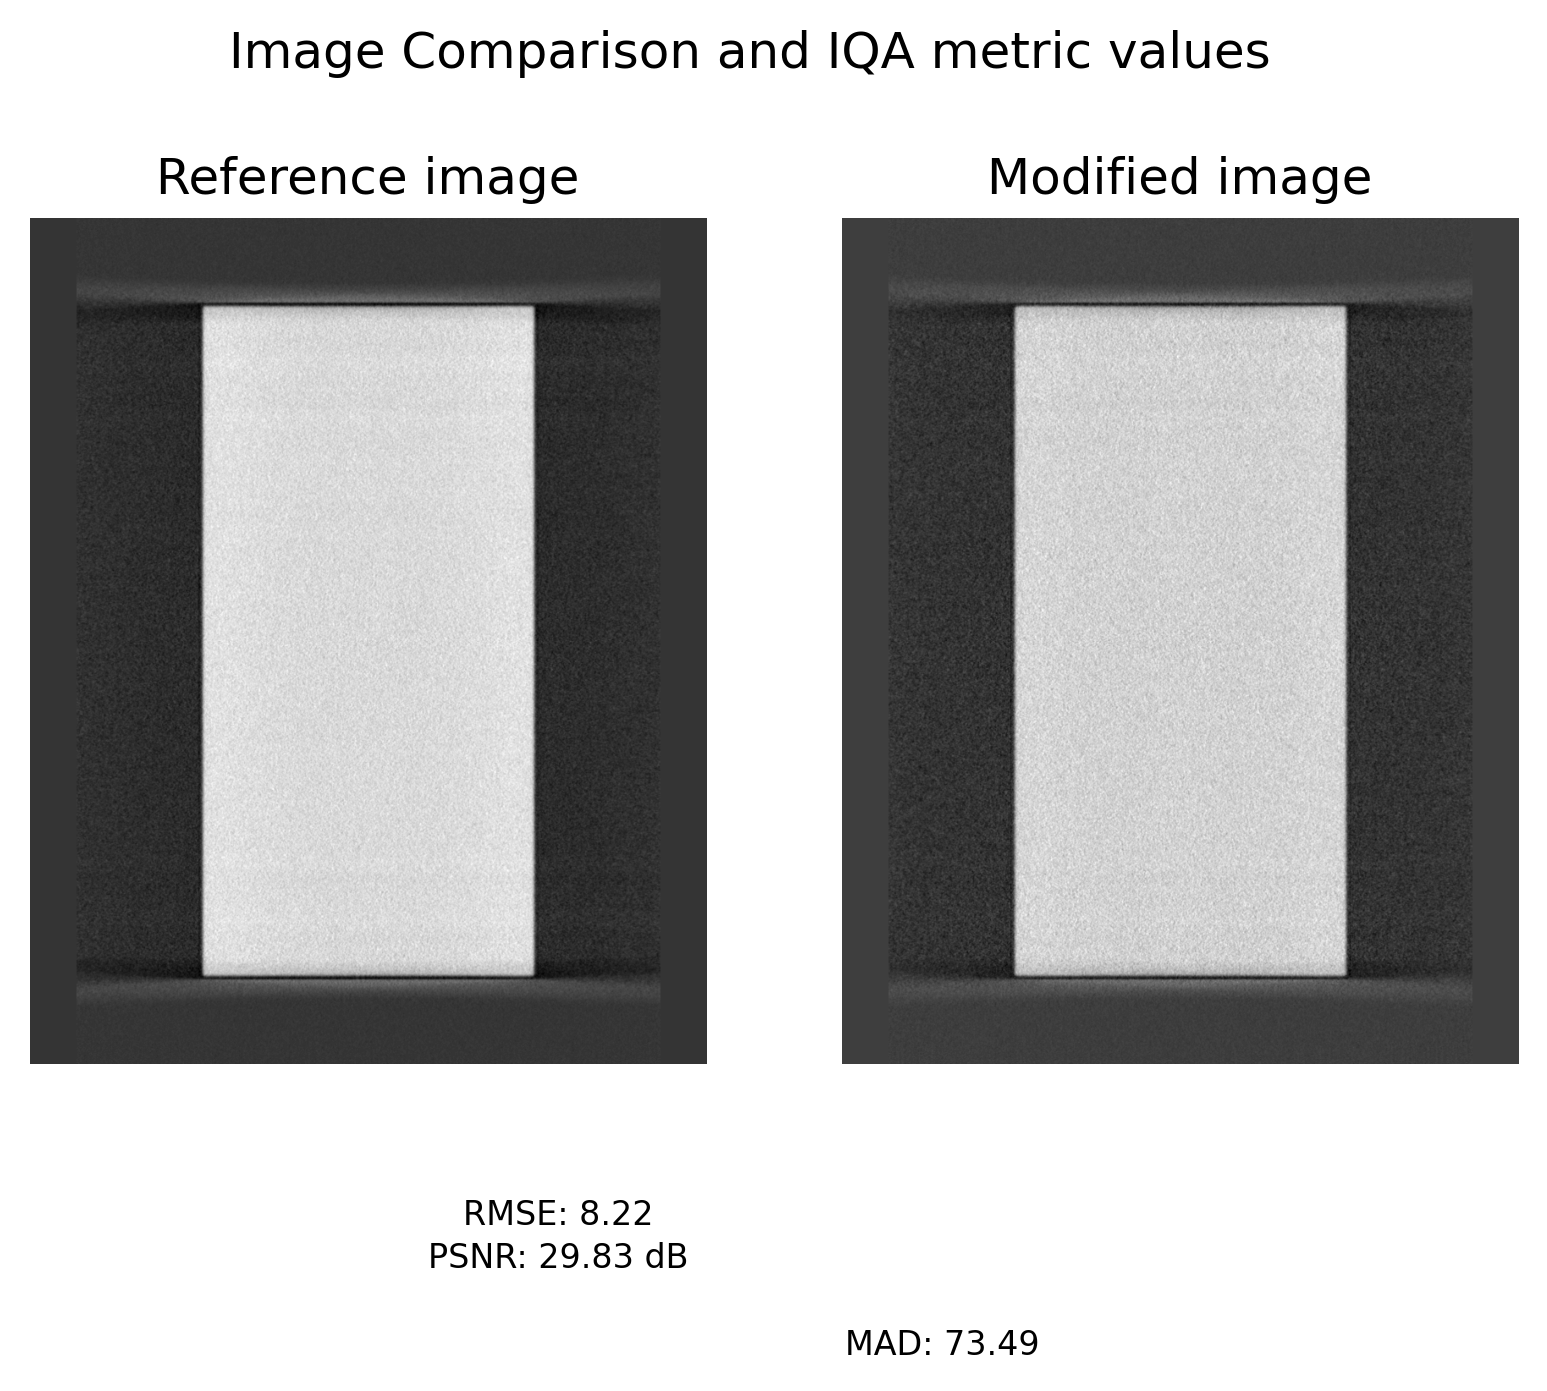

In [25]:
fig, axs = plt.subplots(1,2, dpi=300)
axs[0].imshow(img_r_plot, cmap="gray")
axs[1].imshow(img_m_plot, cmap="gray")

fig.suptitle('Image Comparison and IQA metric values', y=0.92)
axs[0].set_title('Reference image')
axs[1].set_title('Modified image')

if calc_psnr:
    fig.text(0.4, 0.09, f'RMSE: {metric_rmse_m.score_val:.2f}', ha='center', fontsize=8)
if calc_rmse:
    fig.text(0.4, 0.06, f'PSNR: {metric_psnr_m.score_val:.2f} dB', ha='center', fontsize=8)
if calc_ssim:
    fig.text(0.4, 0.03, f'SSIM: {metric_ssim_m.score_val:.2f}', ha='center', fontsize=8)
if calc_msssim:
    fig.text(0.4, 0.00, f'MS-SSIM: {metric_msssim_m.score_val:.2f}', ha='center', fontsize=8)
if calc_fsim:
    fig.text(0.6, 0.09, f'FSIM: {metric_fsim_m.score_val:.2f}', ha='center', fontsize=8)
if calc_vif:
    fig.text(0.6, 0.06, f'VIFp: {metric_vifp_m.score_val:.2f}', ha='center', fontsize=8)
if calc_vsi:
    fig.text(0.6, 0.03, f'VSI: {metric_vsi_m.score_val:.2f}', ha='center', fontsize=8)
if calc_mad:
    fig.text(0.6, 0.00, f'MAD: {metric_mad_m.score_val:.2f}', ha='center', fontsize=8)
    
axs[0].axis('off')
axs[1].axis('off');